In [1]:
%matplotlib widget
# %matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.dpi'] = 150


default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = ['o', '*', 's', '^']

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

### Set save data

In [4]:
save_data = False

In [5]:
def prev_data(expt_path, filename=None):
    """Reopen saved data"""
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_240617


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
# config_path = os.path.join('S:\Seb\experiements\qram_tprocv1_expts\configs', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Load config

In [30]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

print(list(im))
# print(im)

['Pyro.NameServer', 'Heman', 'qdac', 'bkp', 'Qick60', 'SC_26C1', 'SC_2FF1', 'scqubA', 'scredA', 'scqubB', 'scredB', 'YOKO4', 'RS', 'Qick_QRAM', 'NeonFilament']


In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

# Qubit/resonator to probe

In [11]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [12]:
qubit_i = 1
results_Qi = all_results[qubit_i]

## Set reps and rounds

In [61]:
reps = 100
rounds = 5

# Resonator spectro

In [62]:
qubit_i = 1

In [71]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
# rspec.cfg = AttrDict(deepcopy(yaml_cfg))



span = 5 # MHz
npts = 100
rspec.cfg.expt = dict(
    start= rspec.cfg.device.readout.frequency[qubit_i]-0.5*span, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,
    full_mux_expt = True, 
    mask = [0,1,2,3],
    full_mux_ch = 4,
)
rspec.cfg.device.readout.gain[qubit_i] = 0.4
rspec.cfg.device.readout.readout_length = 3
rspec.cfg.expt.lengths = [rspec.cfg.device.readout.readout_length]*4
rspec.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us] - should be 5x resonator lifetime for good shape

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/100 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) -0.060196231652798485
[5794.9366666, 28974.683332999997, 28974.683332999997, 0, 0.019900959405440934, 0]
Attempted to init fitparam 5 to 0, which is out of bounds 0 to 1.014119889465985. Instead init to 0.5070599447329925
[ 5.79488546e+03  7.06090904e+03  3.43611294e+04 -5.97071552e-02
  1.62786869e-02  1.05351269e-39]

Freq with minimum transmission: -705.2383333999999
Freq with maximum transmission: -702.7383333999999
From fit:
	f0: 5794.88545925232
	Qi: 7060.909041064199 	 kappa_i/2pi: 0.8206996330856193
	Qe: 34361.12941832764 	 kappa_e/2pi: 0.16864653628531276
	Q0: 5857.288013695907
	kappa [MHz]: 0.989346169370932
	phi [radians]: -0.0597071552108432


 s:\Seb\experiements\qram_tprocv1_expts\experiments\single_qubit\resonator_spectroscopy.py: 154

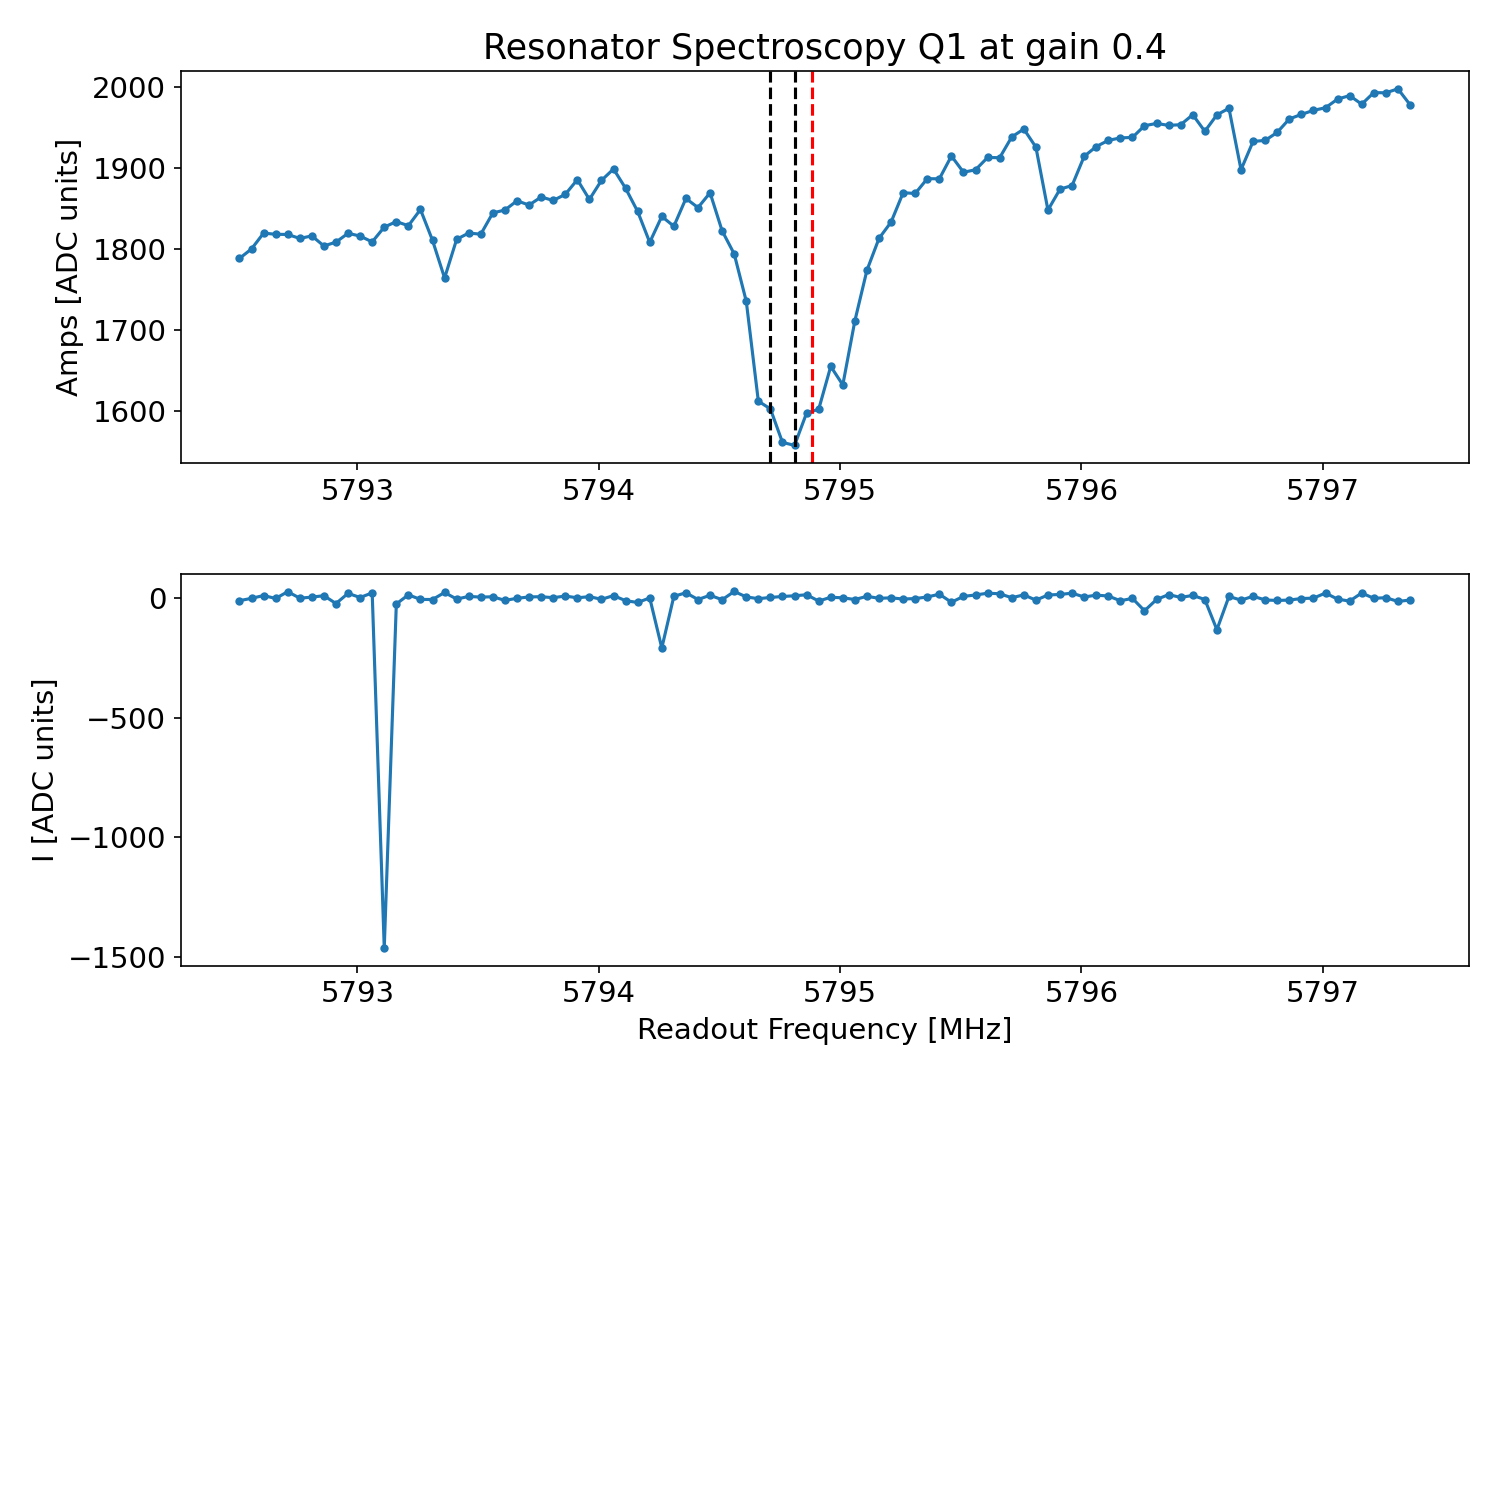

*Set cfg res 1 freq to -705.1883333999998*
*Set cfg res 1 gain to 0.4*


NameError: name 'results_Qi' is not defined

In [72]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.data = rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=False)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

res_freq_g = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
# res_freq_g = rspec.data['xpts'][np.argmax(rspec.data['amps'])]
yaml_cfg.device.readout.frequency[qubit_i] = res_freq_g

yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain[qubit_i]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq[qubit_i])})
results_Qi.update({'Res freq (yaml)':yaml_cfg.device.readout.frequency[qubit_i]})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(f'qubit {qubit_i}', results_Qi)

# Spectro versus power

In [91]:
span_f = 6 # MHz
npts_f = 100

stop_gain = 0.7
start_gain = 0.1
npts_gain = 6

step_gain = (stop_gain - start_gain)/npts_gain

reps = 50




### Ground state

In [92]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

rpowspec.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_gain=start_gain, # Gain start value
    step_gain=step_gain, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=reps, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qTest=qubit_i,
    full_mux_expt = True,
    mask = [0,1,2,3],
    full_mux_ch = 4,
)
rpowspec.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us]
rpowspec.cfg.device.readout.readout_length = 3
rpowspec.cfg.expt.lengths = [rpowspec.cfg.device.readout.readout_length]*4

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [308.97472824556644, -705.0383333999998, 1201.2882333333337, 470.05089277000025], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': 3, 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': 300}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.996526541673, 4572.845483074933, 0.0, 4209.8719428597715, 4205.61697813965, 0.0, 4208.228379127735], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.653411

  0%|          | 0/7 [00:00<?, ?it/s]

qubit 1


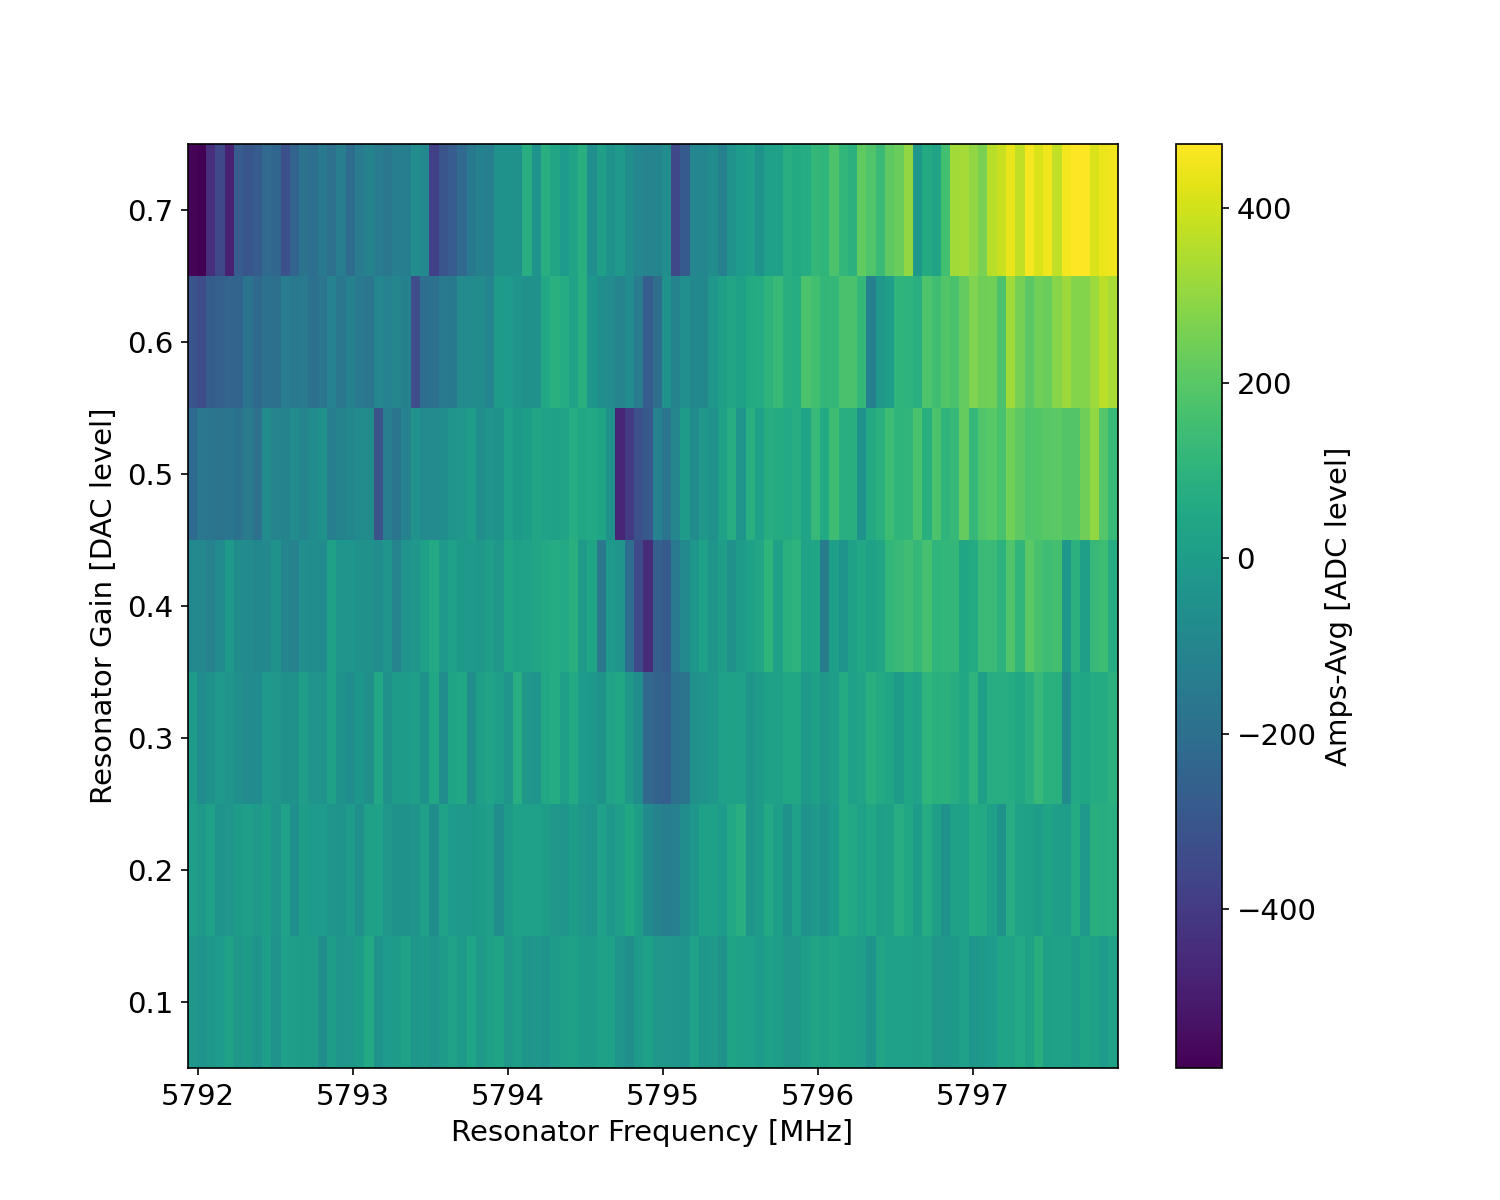

plotting at gain 0.3 index 2
plotting at gain 0.4 index 3
plotting at gain 0.5 index 4
plotting at gain 0.6 index 5
plotting at gain 0.7 index 6
Saving S:\QRAM\qram_4QR2\data\data_240617\00004_power_sweep_resonator_spectroscopy_qubit1.h5


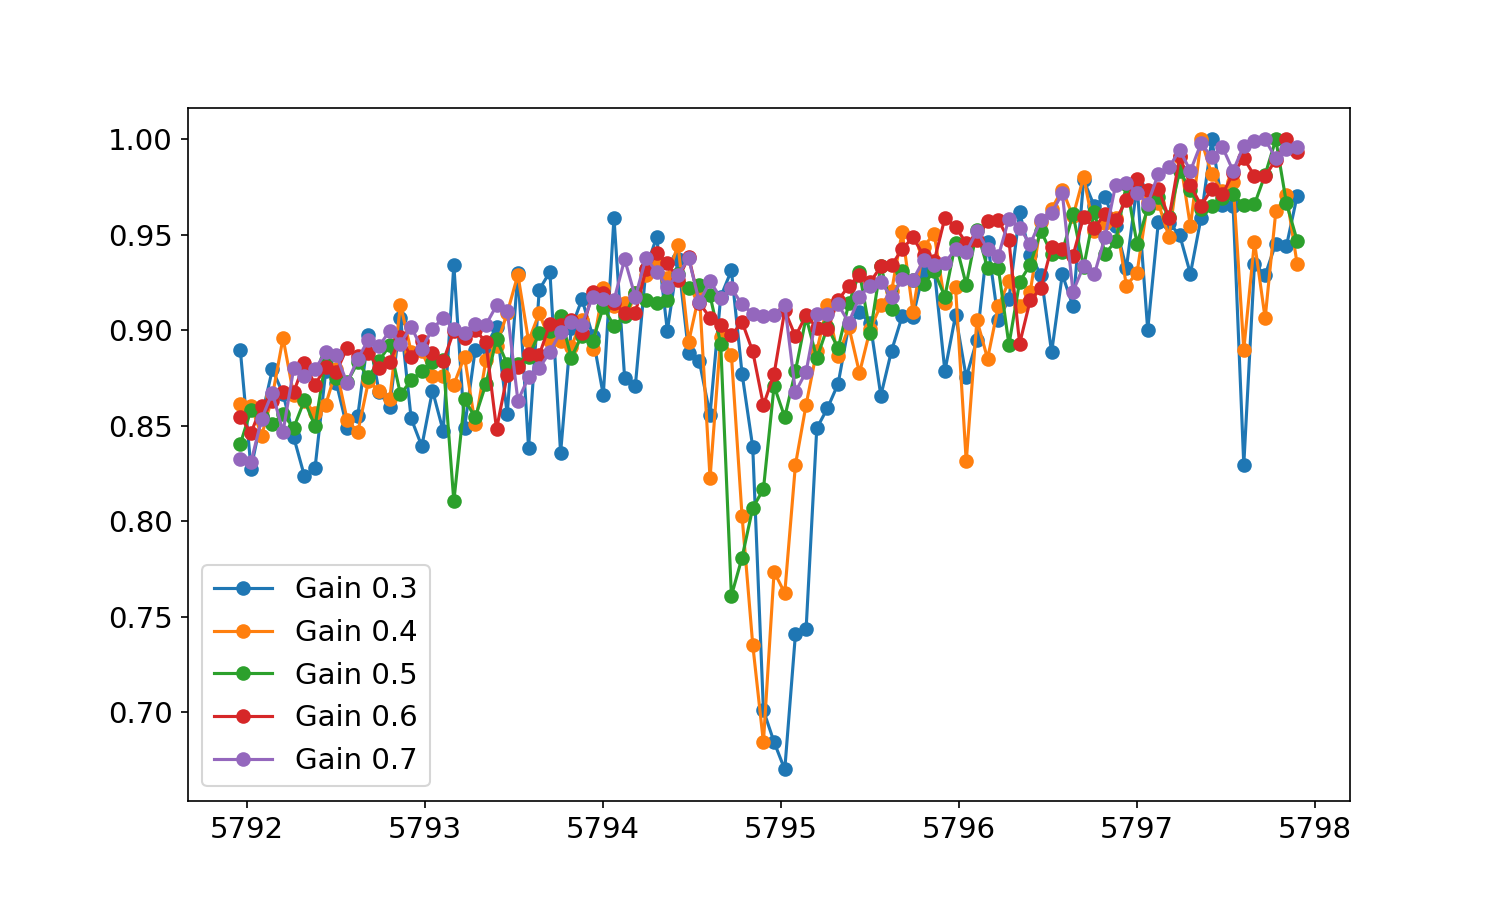

In [95]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec.cfg.expt.qTest)
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False, select=[0.3, 0.4, 0.5, 0.6, 0.7])  

rpowspec.save_data() 

In [96]:
data_g = rpowspec.data
amp_g = rpowspec.data['amps']
avgi_g = rpowspec.data['avgi']
avgq_g = rpowspec.data['avgq']

### E state

In [98]:
rpowspec_e = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

rpowspec_e.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.66, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_gain=start_gain, # Gain start value
    step_gain=step_gain, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=reps, # Number averages per point
    pulse_e=True, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qTest=qubit_i,
    full_mux_expt = True,
    mask = [0,1,2,3],
    full_mux_ch = 4,
)
rpowspec_e.cfg.device.readout.relax_delay = 400 # Wait time between experiments [us]
rpowspec_e.cfg.device.readout.readout_length = 3
rpowspec_e.cfg.expt.lengths = [rpowspec_e.cfg.device.readout.readout_length]*4

print(rpowspec_e.cfg)

rpowspec_e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [308.97472824556644, -705.0383333999998, 1201.2882333333337, 470.05089277000025], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': 3, 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': 400}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.996526541673, 4572.845483074933, 0.0, 4209.8719428597715, 4205.61697813965, 0.0, 4208.228379127735], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.653411

  0%|          | 0/7 [00:00<?, ?it/s]

qubit 1


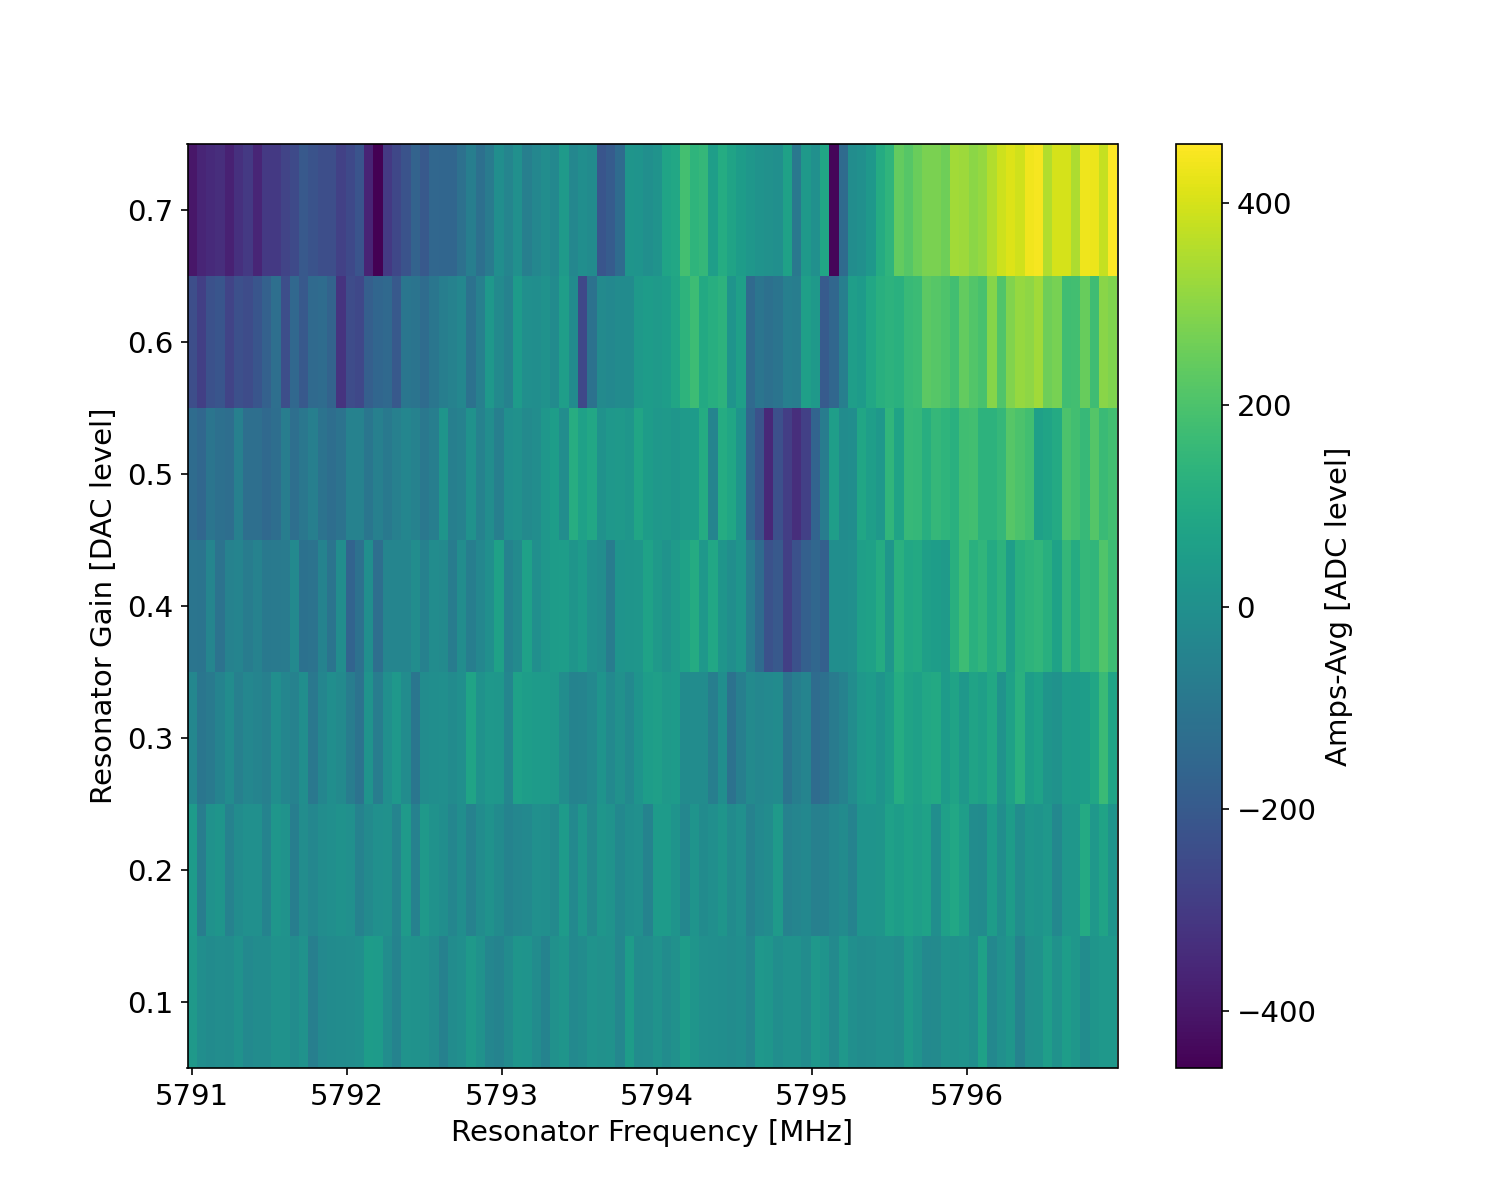

plotting at gain 0.3 index 2
plotting at gain 0.4 index 3
plotting at gain 0.5 index 4
plotting at gain 0.6 index 5
plotting at gain 0.7 index 6
Saving S:\QRAM\qram_4QR2\data\data_240617\00005_power_sweep_resonator_spectroscopy_qubit1.h5


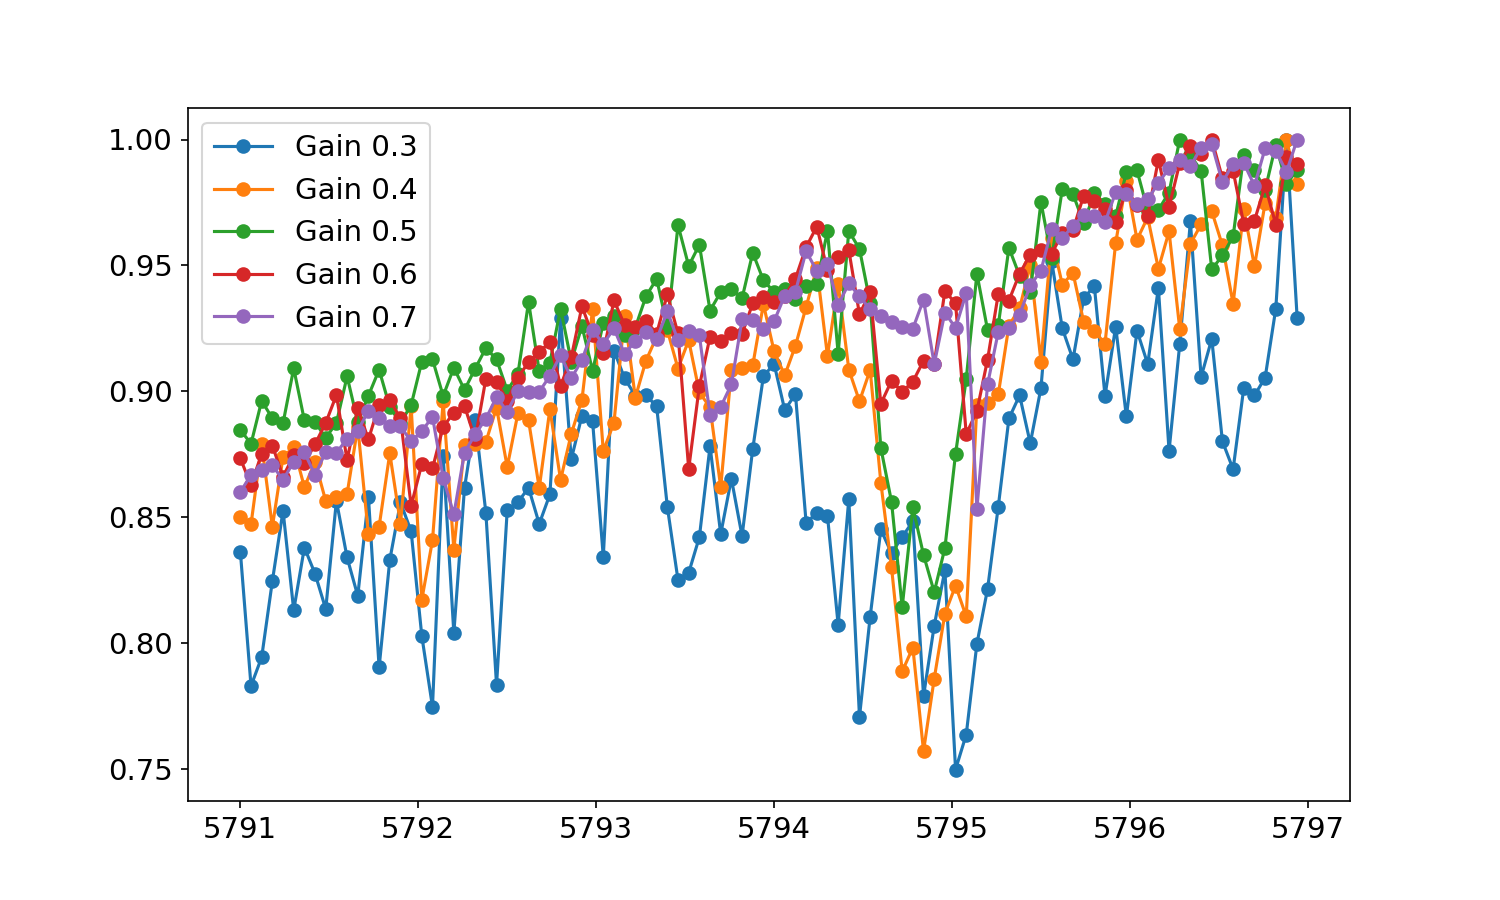

In [99]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec_e.cfg.expt.qTest)
rpowspec_e.analyze(fit=False, lowgain=None, highgain=None)
rpowspec_e.display(fit=False, select=[0.3, 0.4, 0.5, 0.6, 0.7])

rpowspec_e.save_data()

In [100]:
data_e = rpowspec_e.data
amp_e = rpowspec_e.data['amps']

avgi_e = rpowspec_e.data['avgi']
avgq_e = rpowspec_e.data['avgq']

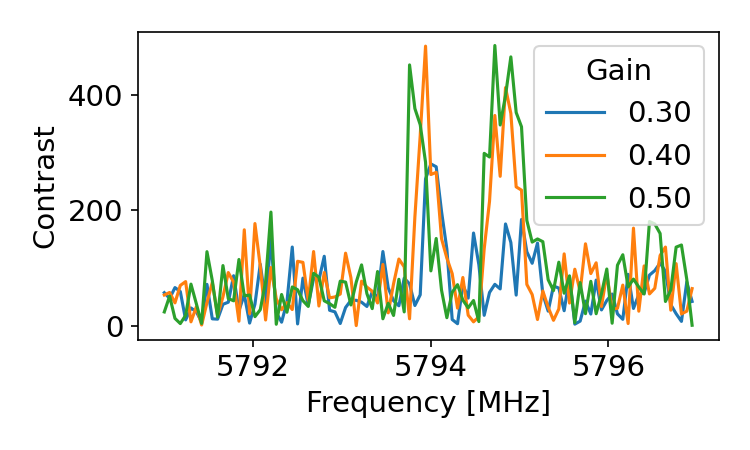

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
contrast = np.abs(amp_e - amp_g)
# contrast = np.sqrt((avgi_g - avgi_e)**2 + (avgq_g - avgq_e)**2)

gain_plot = np.array([0.3, 0.4, 0.5])
idx_plot = np.array([np.argmin(np.abs(data_e['gainpts'] - g)) for g in gain_plot])

# nb_plot = 10
# idx_plot = np.linspace(0, len(data_e['gainpts'])-1, nb_plot).astype(int)



[ax.plot(data_e['xpts'] + yaml_cfg.hw.soc.dacs.readout.mixer_freq, contrast[i], label=f'{data_e["gainpts"][i]:.2f}') for i in (idx_plot)]

ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Contrast')

ax.legend(title='Gain')

fig.tight_layout()

# Single shots

In [107]:
qubit_i = 3

shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_e=True,
    check_f=False,
    qTest=qubit_i,
    
)




shot.cfg.device.readout.frequency[qubit_i]= 5794 - yaml_cfg.hw.soc.dacs.readout.mixer_freq
shot.cfg.device.readout.gain[qubit_i]= 0.4
shot.cfg.device.readout.readout_length[qubit_i] = 3
shot.cfg.expt.lengths = [shot.cfg.device.readout.readout_length]*4
shot.cfg.device.readout.relax_delay = 500  # Wait time between experiments [us]
# set the gains 

print('qubit', shot.cfg.expt.qTest)
print('readout params', shot.cfg.device.readout)

shot.go(analyze=False, display=False, progress=True, save=False)

qubit 3
readout params {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [308.97472824556644, -705.0383333999998, 1201.2882333333337, -706], 'gain': [0.04, 0.03, 0.18, 0.4], 'readout_length': [15.0, 10.0, 5.0, 3], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': 500}


TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [ ]:
print(shot.cfg)
shot.display(fit=False) 

## sweeps

In [24]:
qubit_i = 1

shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

span_f = 1
npts_f = 20
start_f = 5794.2


start_gain = 0.005
stop_gain = 0.035
npts_gain = 10
step_gain = (stop_gain - start_gain) / npts_gain

span_len = 5 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=1000,
    qTest=qubit_i,
    start_f=start_f, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=start_gain,
    step_gain=step_gain,
    expts_gain=npts_gain + 1,
    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

shotopt.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

freq: 5794.2, gain: 0.005, len: 3.0
	fid ge [%]: 13.406703351675839
freq: 5794.2, gain: 0.008, len: 3.0
	fid ge [%]: 14.607303651825912
freq: 5794.2, gain: 0.011, len: 3.0
	fid ge [%]: 11.700000000000001
freq: 5794.2, gain: 0.014000000000000002, len: 3.0
	fid ge [%]: 10.100000000000001
freq: 5794.2, gain: 0.017, len: 3.0
	fid ge [%]: 12.506253126563283
freq: 5794.2, gain: 0.02, len: 3.0
	fid ge [%]: 11.105552776388194
freq: 5794.2, gain: 0.023000000000000003, len: 3.0
	fid ge [%]: 13.306653326663332
freq: 5794.2, gain: 0.026000000000000002, len: 3.0
	fid ge [%]: 9.2
freq: 5794.2, gain: 0.029, len: 3.0
	fid ge [%]: 6.9
freq: 5794.2, gain: 0.032, len: 3.0
	fid ge [%]: 18.10905452726363
freq: 5794.2, gain: 0.034999999999999996, len: 3.0
	fid ge [%]: 16.2
freq: 5794.25, gain: 0.005, len: 3.0
	fid ge [%]: 12.706353176588294
freq: 5794.25, gain: 0.008, len: 3.0
	fid ge [%]: 11.5
freq: 5794.25, gain: 0.011, len: 3.0
	fid ge [%]: 10.705352676338169
freq: 5794.25, gain: 0.014000000000000002, le

(7, 9, 0)
[5794.2  5794.25 5794.3  5794.35 5794.4  5794.45 5794.5  5794.55 5794.6
 5794.65 5794.7  5794.75 5794.8  5794.85 5794.9  5794.95 5795.   5795.05
 5795.1  5795.15]
[0.005 0.008 0.011 0.014 0.017 0.02  0.023 0.026 0.029 0.032 0.035]
[3.]
Max fidelity 47.223611805902955 %
Set params: 
 angle (deg) 156.41990448821358 
 threshold -2822.3595466842335 
 freq [Mhz] 5794.55 
 gain [dac units] 0.032 
 readout length [us] 3.0
Optimal readout length 3.0 us
(20, 11, 1) (11,) (20,) (1,)


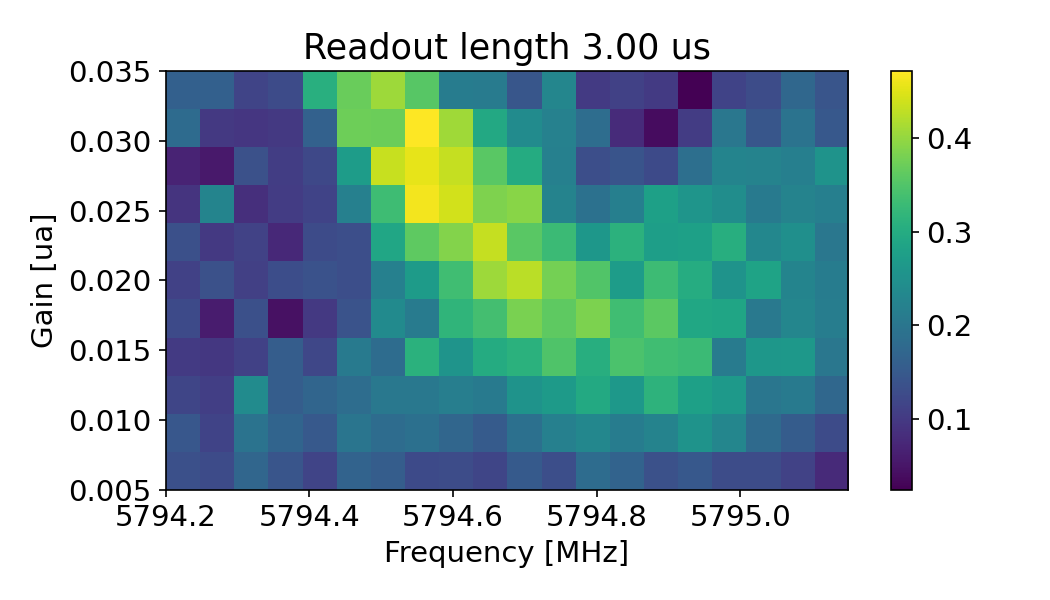

In [25]:
imax = shotopt.analyze()

print(f'Optimal gain {shotopt.data["gainpts"][imax[1]]},  frequency {shotopt.data["fpts"][imax[0]]} MHz' and f'Optimal readout length {shotopt.data["lenpts"][imax[2]]} us')


# shotopt.display()
fid = shotopt.data['fid']
gain = shotopt.data['gainpts']
fpts = shotopt.data['fpts']
lenpts = shotopt.data['lenpts']

print(fid.shape, gain.shape, fpts.shape, lenpts.shape)


# print 2d plot of the fidelity versus gain and frequency for each readout length
# fid is a 3d array with shape (len(fpts), len(gain), len(lenpts))

for i in range(len(lenpts)):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.imshow(fid[:, ::-1, i].T, aspect='auto', extent=[fpts[0], fpts[-1], gain[0], gain[-1]])
    ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('Gain [ua]')
    ax.set_title(f'Readout length {lenpts[i]:.2f} us')
    # add colorbar
    ax.figure.colorbar(ax.images[0], ax=ax)
    fig.tight_layout()



In [ ]:
# plot the slice for the longest readout length


for l in lenpts:
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    [ax.plot(fpts, fid[:, i, np.argmin(np.abs(lenpts - l))], label=f'{gain[i]:.2f}') for i in range(len(gain))]

    ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('Fidelity')
    ax.legend(title='Gain')
    ax.set_title(f'Readout length {l:.2f} us')
    fig.tight_layout()

# fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# [ax.plot(fpts, fid[:, i, -1], label=f'{gain[i]:.2f}') for i in range(len(gain))]

# ax.set_xlabel('Frequency [MHz]')
# ax.set_ylabel('Fidelity')
# ax.legend(title='Gain')

# fig.tight_layout()

In [ ]:
shotopt.save_data()

## Multi-readout

In [21]:
qubit_i = 1

  0%|          | 0/20 [00:00<?, ?it/s]

Finished 0/20 0/10 0/1
freq: -705.8000000000002 gain: 0.02 length: 3.0
Fidelity: 0.01823623623623627
Finished 0/20 1/10 0/1
freq: -705.8000000000002 gain: 0.032 length: 3.0
Fidelity: 0.039000000000000035
Finished 0/20 2/10 0/1
freq: -705.8000000000002 gain: 0.044 length: 3.0
Fidelity: 0.03458658658658659
Finished 0/20 3/10 0/1
freq: -705.8000000000002 gain: 0.05600000000000001 length: 3.0
Fidelity: 0.04200000000000004
Finished 0/20 4/10 0/1
freq: -705.8000000000002 gain: 0.068 length: 3.0
Fidelity: 0.056999999999999995
Finished 0/20 5/10 0/1
freq: -705.8000000000002 gain: 0.08 length: 3.0
Fidelity: 0.07100000000000001
Finished 0/20 6/10 0/1
freq: -705.8000000000002 gain: 0.09200000000000001 length: 3.0
Fidelity: 0.04699999999999993
Finished 0/20 7/10 0/1
freq: -705.8000000000002 gain: 0.10400000000000001 length: 3.0
Fidelity: 0.039000000000000035
Finished 0/20 8/10 0/1
freq: -705.8000000000002 gain: 0.116 length: 3.0
Fidelity: 0.04399999999999993
Finished 0/20 9/10 0/1
freq: -705.80000

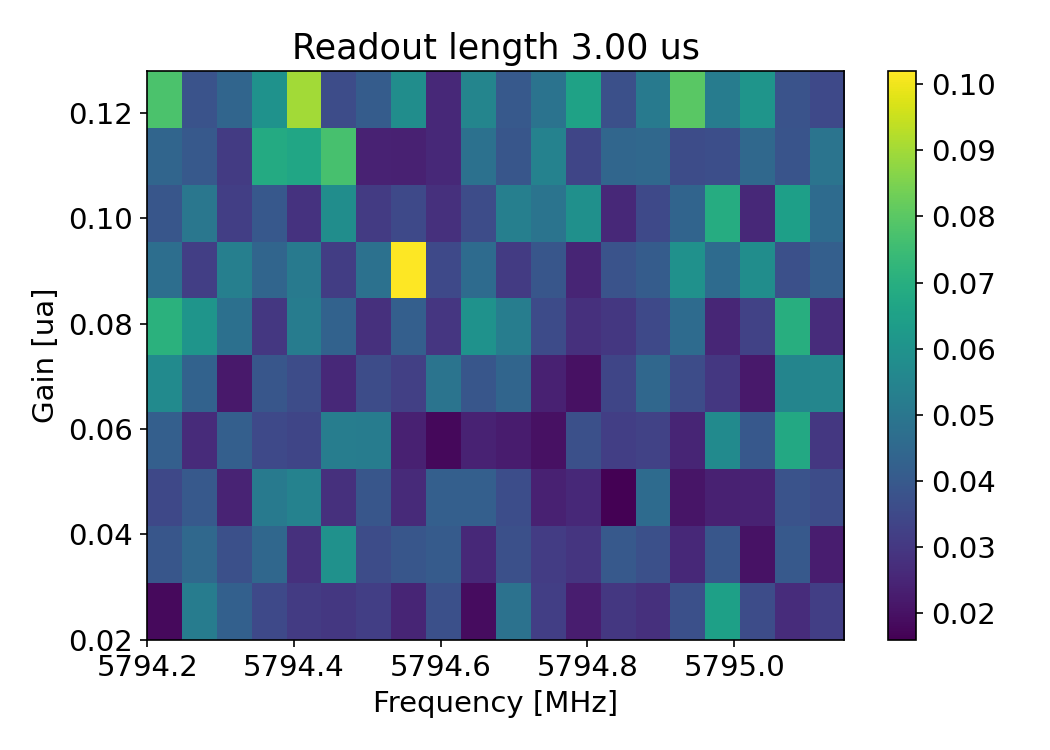

In [36]:

for qubit_i in [1]:


    multishotopt = meas.MultiReadoutOptExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"multi_readout_opt_qubit{qubit_i}",
        config_file=config_path,
    )

    multishotopt.cfg = AttrDict(deepcopy(yaml_cfg))

    span_f = 1
    npts_f = 20
    start_f = 5794.2 - yaml_cfg.hw.soc.dacs.readout.mixer_freq # [MHz]


    start_gain = 0.005*4
    stop_gain = 0.035*4
    npts_gain = 10
    step_gain = (stop_gain - start_gain) / npts_gain

    start_len = 3
    span_len = 5 # us
    npts_len = 1

    multishotopt.cfg.expt = dict(
        reps=1000,
        qTest=qubit_i,
        start_f=start_f, # [MHz]
        step_f=span_f/npts_f,
        expts_f=npts_f,
        start_gain=start_gain,
        step_gain=step_gain,
        expts_gain=npts_gain,
        start_len=start_len,
        step_len=span_len/npts_len,
        expts_len=npts_len,
        check_e=True,
        check_f=False,
        readout_cool = True, 
        n_init_readout = 1, 
        n_trig = 1,
        init_read_wait_us = 10, 
        avg_trigs = True,
        amplitude_mode = True,
        full_mux_expt = True, 
        )

    if multishotopt.cfg.expt.full_mux_expt:
        multishotopt.cfg.expt.mask = [0,1,2,3]
        multishotopt.cfg.expt.full_mux_ch = 4





    multishotopt.go(analyze=False, display=False, progress=True, save=False)
    multishotopt.save_data()
    multishotopt.display()




In [1]:
multishotopt.display()

NameError: name 'multishotopt' is not defined

In [ ]:
imax = multishotopt.analyze()

print(f'Optimal gain {multishotopt.data["gainpts"][imax[1]]}')
print(f'Optimal frequency {multishotopt.data["fpts"][imax[0]]} MHz')
print(f'Optimal readout length {multishotopt.data["lenpts"][imax[2]]} us')
print(f'Fidelity {multishotopt.data["fid"][imax[0], imax[1], imax[2]]}')


In [ ]:
imax

In [111]:
qubit_i = 1
gain_vec = np.array([0.4])
readout_vec = np.array([4.0])
wait_vec = np.array([10])
n_trig = np.array([1])
freq =  5794 - yaml_cfg.hw.soc.dacs.readout.mixer_freq

for t in n_trig:
    for w in wait_vec:
        for r in readout_vec:
            for g in gain_vec:
                print('gain', g, 'readout length', r)
                
                shot = meas.MultiReadoutExperiment(
                    soccfg=soc,
                    path=expt_path,
                    prefix=f"multi_readout_qubit{qubit_i}",
                    config_file=config_path,
                )

                shot.cfg.expt = dict(
                    reps=1000,
                    check_e=True,
                    check_f=False,
                    qTest=qubit_i,
                    readout_cool=True,
                    n_init_readout=1, # number of readout blocks prior to final readout
                    n_trig=t, # extend readout by triggering this many times in a row
                    init_read_wait_us=w, # wait between readout blocks
                    use_gf_readout=False,
                    avg_trigs=True, # whether to combine data from trigger stacks into 1 averaged histogram
                    full_mux_expt = True, 
  
                )
                if shot.cfg.expt.full_mux_expt:
                    shot.cfg.expt.lengths = [r]*4
                    shot.cfg.device.readout.readout_length = shot.cfg.expt.lengths
                    shot.cfg.expt.mask = [0,1,2,3]
                    shot.cfg.expt.full_mux_ch = 4
                else:
                    for q in range(4):
                        shot.cfg.device.readout.readout_length[q] = r
                shot.cfg.device.readout.frequency[qubit_i]= freq
                shot.cfg.device.readout.gain[qubit_i] = g
                print('qubit', shot.cfg.expt.qTest)

                try:
                    shot.go(analyze=False, display=False, progress=True, save=False)
                except Exception:
                    print("Pyro traceback:")
                    print("".join(Pyro4.util.getPyroTraceback()))
                    
                shot.analyze(fit=False, check_readouts=[0], post_select=False, verbose=False, amplitude_mode=True, plot=True)
                # shot.display(fit=False, post_select=False, verbose=False, export=False)
                
                shot.save_data()
                

gain 0.4 readout length 4.0
qubit 1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

check states ['g', 'e', 'g_0', 'e_0']


UnboundLocalError: local variable 'check_qubit_label' referenced before assignment

In [49]:
sidebands = np.array(multishotopt.cfg.device.readout.frequency)
mux = 6500

In [50]:
gen_freqs_up = mux + sidebands
gen_freqs_down = mux - sidebands
print(sidebands)
print(gen_freqs_up, gen_freqs_down)

[ 308.97472825 -705.0383334  1201.28823333  470.05089277]
[6808.97472825 5794.9616666  7701.28823333 6970.05089277] [6191.02527175 7205.0383334  5298.71176667 6029.94910723]


In [32]:
# shift the sideband by -400 and compute the new desired sideband frequencies so that the gen_freqs_up are the same

mux = 6600
sidebands = gen_freqs_up - mux
print(sidebands)

[ 208.97472825 -805.0383334  1101.28823333  370.05089277]


In [33]:
5794.2 - 6500

-705.8000000000002

In [35]:
yaml_cfg.hw.soc.dacs.readout.mixer_freq

6500